In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

torch.manual_seed(42)

In [2]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

target_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: np.round(x)), # Round the labels to get integer like labels
    transforms.Lambda(lambda x: x - 1.9), # labels will go from (1, 2, 3) to (-0.9, 0.1, 1.1)
    transforms.Lambda(lambda x: np.minimum(x, 0)), # labels will be (-0.9, 0)
    transforms.Lambda(lambda x: 1 - np.round(x + 0.9)), # labels will be (0, 1) where 1 is pet, 0 is everything else
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(128, 128).long()),
    
])

In [3]:
dataset = torchvision.datasets.OxfordIIITPet(
    root='./pets',
    split='trainval',
    target_types='segmentation',
    download=True,
    transform=image_transforms,
    target_transform=target_transforms
)

# What We're Building

(Modified from the original source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

![](./u-net-architecture-edit.png)

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, f_in : int, f_out : int):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(
                in_channels=f_in,
                out_channels=f_out,
                kernel_size = (3, 3),
                padding = 'same'
            ),
            nn.BatchNorm2d(num_features=f_out),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=f_out,
                out_channels=f_out,
                kernel_size = (3, 3),
                padding = 'same'
            ),
            nn.BatchNorm2d(num_features=f_out),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.convs(x)

    
    
class UpConv(nn.Module):
    def __init__(self, f_in : int, f_out : int):
        super().__init__()
        
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(
            in_channels = f_in,
            out_channels = f_out,
            kernel_size = (2, 2),
            padding = 'same'
        )
    
    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        
        return y

    
class UNet(nn.Module):
    def __init__(self, channels : int, classes : int):
        super().__init__()
        
        # (A)
        self.c1 = ConvBlock(channels, 64)
        self.mp1 = nn.MaxPool2d(2)
        
        # (B)
        self.c2 = ConvBlock(64, 128)
        self.mp2 = nn.MaxPool2d(2)
        
        # (C)
        self.c3 = ConvBlock(128, 256)
        self.mp3 = nn.MaxPool2d(2) # 🎵
        
        # (D)
        self.c4 = ConvBlock(256, 512) # 💣
        self.mp4 = nn.MaxPool2d(2) # 📼
        
        # (E)
        self.c5 = ConvBlock(512, 1024)
        self.up1 = UpConv(1024, 512)
        
        # (F)
        self.c6 = ConvBlock(1024, 512)
        self.up2 = UpConv(512, 256)
        
        # (G)
        self.c7 = ConvBlock(512, 256)
        self.up3 = UpConv(256, 128)
        
        # (H)
        self.c8 = ConvBlock(256, 128)
        self.up4 = UpConv(128, 64)
        
        # (I)
        self.c9 = ConvBlock(128, 64)
        self.c_final = nn.Conv2d(
            in_channels = 64,
            out_channels = classes,
            kernel_size = (1, 1),
            stride = 1,
            padding = 'same'
        )
    
    def forward(self, x):
        # (A)
        y = self.c1(x)
        skip1 = y
        y = self.mp1(y) # 64 x 64
        
        # (B)
        y = self.c2(y)
        skip2 = y
        y = self.mp2(y) # 32 x 32
        
        # (C)
        y = self.c3(y)
        skip3 = y
        y = self.mp3(y) # 16 x 16
        
        # (D)
        y = self.c4(y)
        skip4 = y
        y = self.mp4(y) # 8 x 8
        
        # (E)
        y = self.c5(y)
        y = self.up1(y) # 16 x 16
        
        y = torch.cat((skip4, y), dim=1) # [batch, channels, x, y]
        
        # (F)
        y = self.c6(y)
        y = self.up2(y)
        
        y = torch.cat((skip3, y), dim=1)
        
        # (G)
        y = self.c7(y)
        y = self.up3(y)
        
        y = torch.cat((skip2, y), dim=1)
        
        # (H)
        y = self.c8(y)
        y = self.up4(y)
        
        y = torch.cat((skip1, y), dim=1)
        
        # (I)
        y = self.c9(y)
        y = self.c_final(y)
        
        # Done
        return y

In [5]:
# Define a training loop

hp = {
    'lr': 1e-3,
    'batch_size': 64,
    'epochs': 10
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = UNet(
    channels=3,
    classes=2
).to(device)

loss_fn =  nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=hp['lr'])

images = len(dataset)
train_idx = int(0.8 * images)

train_snip, val_snip = torch.utils.data.random_split(dataset, [train_idx, images - train_idx])

train_dataloader = torch.utils.data.DataLoader(train_snip, hp['batch_size'])
val_dataloader = torch.utils.data.DataLoader(val_snip, hp['batch_size'])

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        prediction = model(X.to(device))
        loss = loss_fn(prediction, y.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            
            print(f"loss: {loss} [{current:>5d}/{size:>5d}]")
            
            pred = nn.functional.softmax(prediction[0], dim=0)
            img = X[0].permute(1, 2, 0) # 3, 128, 128
            
            plt.imshow(img)
            plt.imshow(pred.cpu().detach()[1], alpha=0.75)
            plt.clim(0.0, 1.0)
            plt.colorbar()
            plt.show()
            
            


Using cuda device


============= Batch 0 ===============


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


loss: 0.6631508469581604 [    0/ 2944]


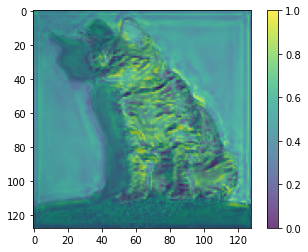

loss: 0.6394056677818298 [ 1280/ 2944]


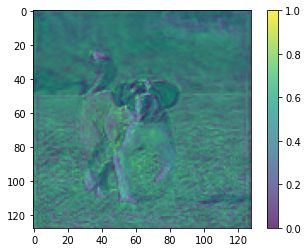

loss: 0.6197092533111572 [ 2560/ 2944]


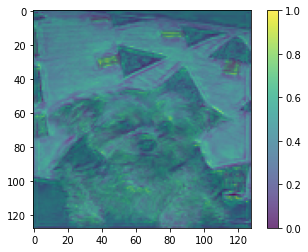

============= Batch 1 ===============
loss: 0.6175333857536316 [    0/ 2944]


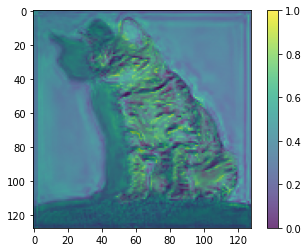

loss: 0.6002336144447327 [ 1280/ 2944]


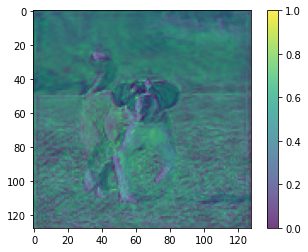

loss: 0.5887433886528015 [ 2560/ 2944]


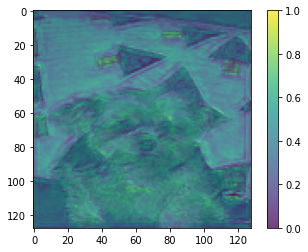

============= Batch 2 ===============
loss: 0.5919908881187439 [    0/ 2944]


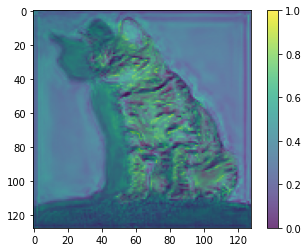

loss: 0.576799213886261 [ 1280/ 2944]


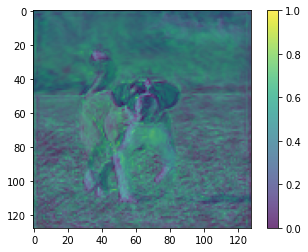

loss: 0.5680449604988098 [ 2560/ 2944]


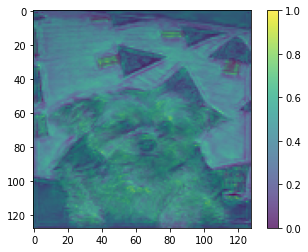

============= Batch 3 ===============
loss: 0.5723037719726562 [    0/ 2944]


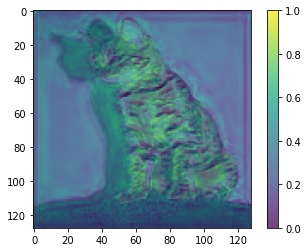

loss: 0.5578843951225281 [ 1280/ 2944]


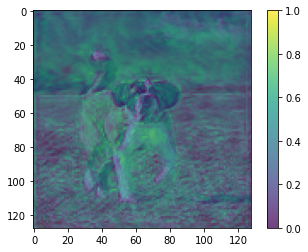

loss: 0.5504437685012817 [ 2560/ 2944]


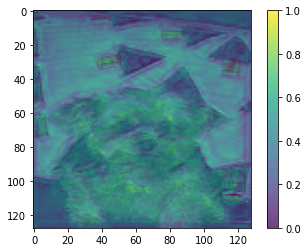

============= Batch 4 ===============
loss: 0.5548097491264343 [    0/ 2944]


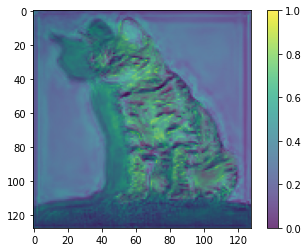

loss: 0.5397429466247559 [ 1280/ 2944]


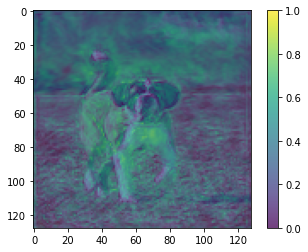

loss: 0.5328531265258789 [ 2560/ 2944]


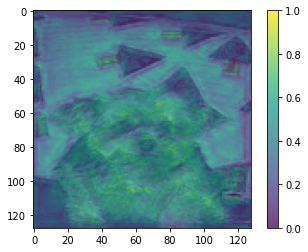

============= Batch 5 ===============
loss: 0.5375580191612244 [    0/ 2944]


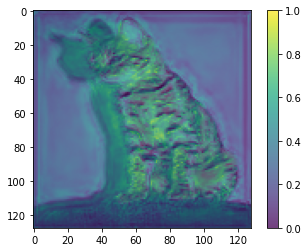

loss: 0.5205572843551636 [ 1280/ 2944]


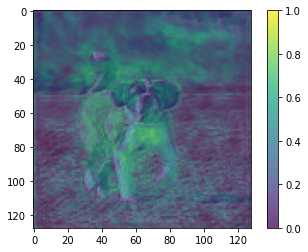

loss: 0.5135190486907959 [ 2560/ 2944]


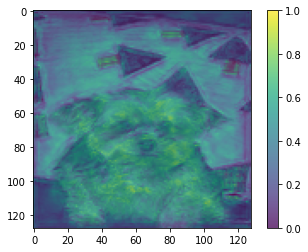

============= Batch 6 ===============
loss: 0.5195347666740417 [    0/ 2944]


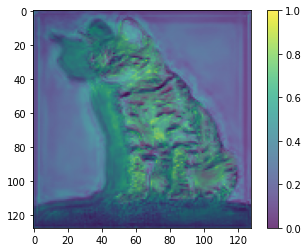

loss: 0.5001271963119507 [ 1280/ 2944]


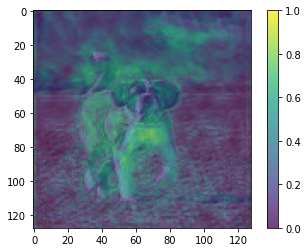

loss: 0.4928959012031555 [ 2560/ 2944]


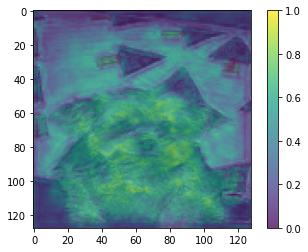

============= Batch 7 ===============
loss: 0.5012518763542175 [    0/ 2944]


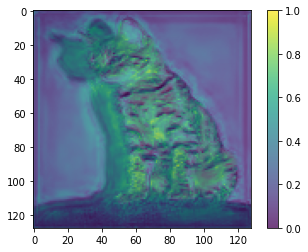

loss: 0.4805870056152344 [ 1280/ 2944]


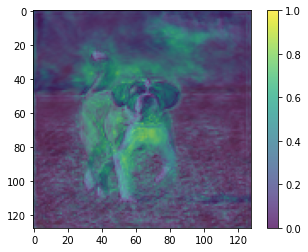

loss: 0.47296270728111267 [ 2560/ 2944]


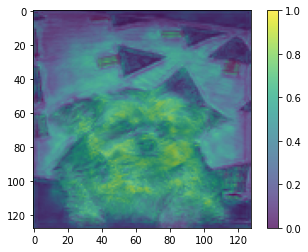

============= Batch 8 ===============
loss: 0.4841073453426361 [    0/ 2944]


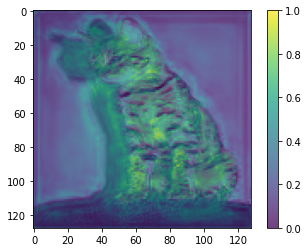

loss: 0.4636062681674957 [ 1280/ 2944]


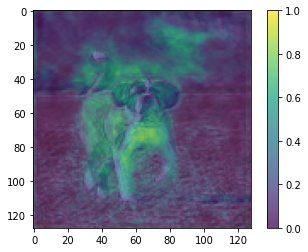

loss: 0.45484092831611633 [ 2560/ 2944]


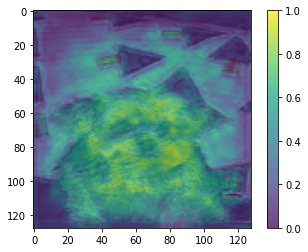

============= Batch 9 ===============
loss: 0.4687351882457733 [    0/ 2944]


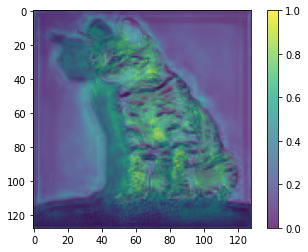

loss: 0.4488731920719147 [ 1280/ 2944]


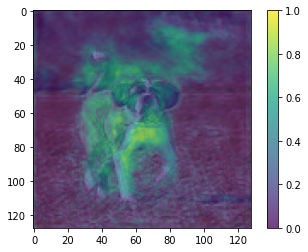

loss: 0.4389023780822754 [ 2560/ 2944]


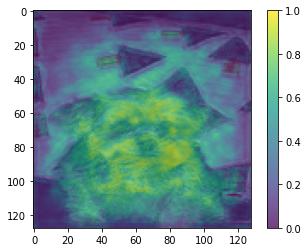

In [6]:
for i in range(hp['epochs']):
    print(f"============= Batch {i} ===============")
    train_loop(train_dataloader, model, loss_fn, optimizer)

loss: 0.45478081703186035 [    0/ 2944]


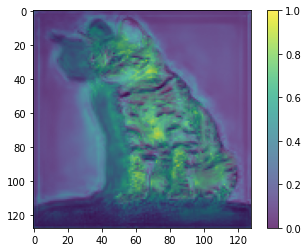

loss: 0.43574386835098267 [ 1280/ 2944]


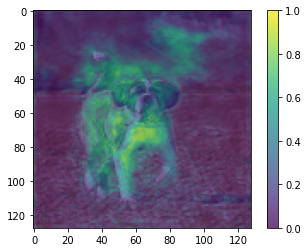

loss: 0.42503979802131653 [ 2560/ 2944]


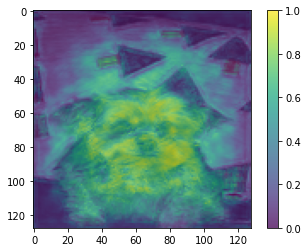

In [7]:
train_loop(train_dataloader, model, loss_fn, optimizer)